총 29814개의 이미지에 자동 최적화 전처리를 시작합니다...


Processing Images: 100%|██████████| 29814/29814 [05:44<00:00, 86.42it/s] 



모든 전처리 작업이 완료되었습니다.
결과는 'kaggle_adaptive_processed' 폴더에 저장되었습니다.


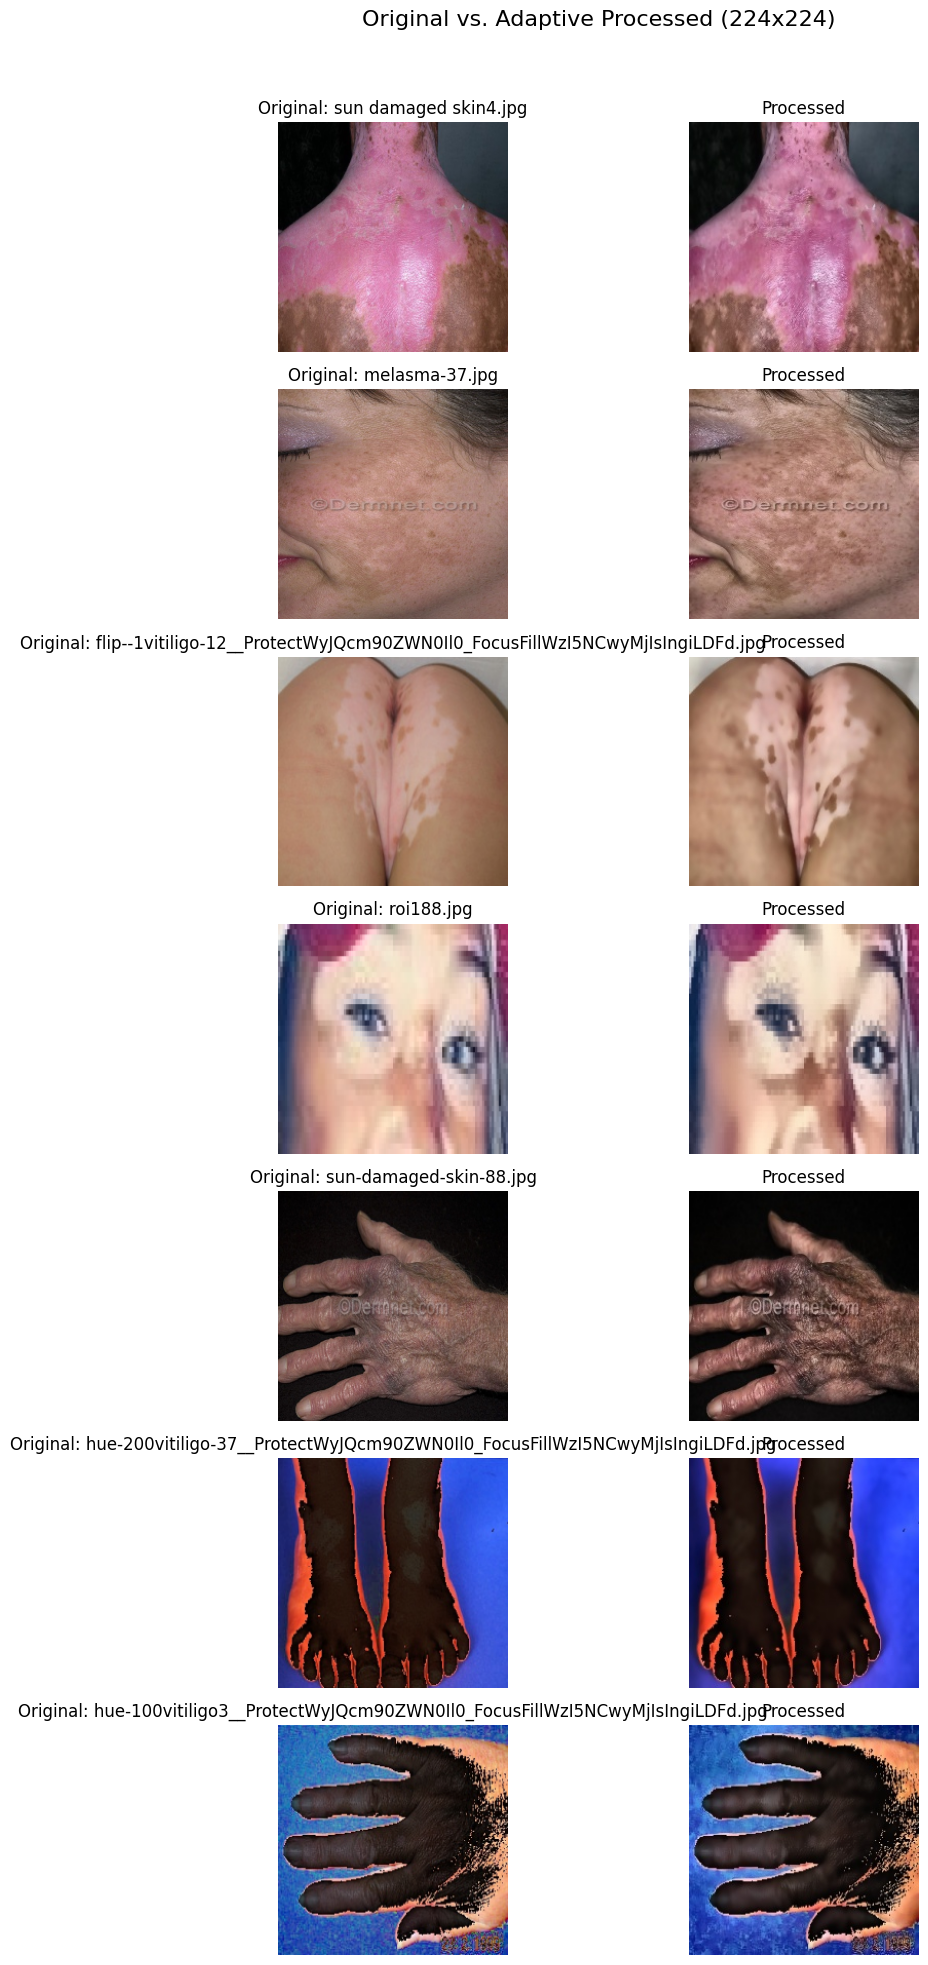

In [2]:
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def calculate_brightness(image):
    """이미지의 평균 밝기를 계산합니다 (0-255)."""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, _, _ = cv2.split(lab)
    return np.mean(l)

def calculate_sharpness(image):
    """이미지의 선명도를 계산합니다 (Laplacian variance)."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

def adaptive_preprocess_image(image):
    """이미지를 분석하여 최적의 전처리를 적용하는 함수"""
    # 1. 이미지 상태 분석
    brightness = calculate_brightness(image)
    sharpness = calculate_sharpness(image)
    
    # 2. 상태에 따라 파라미터 동적 결정
    # 밝기 조절 (Gamma)
    if brightness < 80:  # 너무 어두운 경우
        gamma_value = 0.7
    elif brightness > 180: # 너무 밝은 경우
        gamma_value = 1.3
    else: # 적절한 경우
        gamma_value = 1.0

    # 선명도 조절 (CLAHE)
    if sharpness < 100: # 흐릿한 경우
        clip_limit = 3.0
    else: # 충분히 선명한 경우
        clip_limit = 1.5
        
    # Bilateral Filter 및 리사이즈는 고정값 사용
    clahe_tile_grid_size = (8, 8)
    bilateral_d = 9
    bilateral_sigma = 75
    resize_dim = (224, 224)

    # --- 3. 결정된 파라미터로 전처리 파이프라인 실행 ---
    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=clahe_tile_grid_size)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    cl = clahe.apply(l)
    merged_lab = cv2.merge((cl, a, b))
    processed_image = cv2.cvtColor(merged_lab, cv2.COLOR_LAB2BGR)
    
    # Gamma
    if gamma_value != 1.0:
        inv_gamma = 1.0 / gamma_value
        table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        processed_image = cv2.LUT(processed_image, table)
        
    # Bilateral Filter
    processed_image = cv2.bilateralFilter(processed_image, bilateral_d, bilateral_sigma, bilateral_sigma)
    
    # Resize
    processed_image = cv2.resize(processed_image, resize_dim, interpolation=cv2.INTER_AREA)
    
    return processed_image


def main():
    source_root_path = 'kaggle/train'
    output_root_path = 'kaggle_adaptive_processed/train'

    image_paths = glob.glob(os.path.join(source_root_path, '**', '*.jpg'), recursive=True)
    if not image_paths:
        print(f"오류: '{source_root_path}' 폴더에서 .jpg 이미지를 찾을 수 없습니다.")
        return

    print(f"총 {len(image_paths)}개의 이미지에 자동 최적화 전처리를 시작합니다...")

    for source_path in tqdm(image_paths, desc="Processing Images"):
        source_image = cv2.imread(source_path)
        if source_image is None:
            continue

        processed_image = adaptive_preprocess_image(source_image)

        relative_path = os.path.relpath(source_path, source_root_path)
        output_path = os.path.join(output_root_path, relative_path)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        cv2.imwrite(output_path, processed_image)

    print("\n모든 전처리 작업이 완료되었습니다.")
    print(f"결과는 '{os.path.dirname(output_root_path)}' 폴더에 저장되었습니다.")

    # --- 결과 비교 시각화 ---
    num_to_display = 7
    sample_paths = image_paths[:num_to_display]
    
    fig, axes = plt.subplots(num_to_display, 2, figsize=(10, 20))
    fig.suptitle('Original vs. Adaptive Processed (224x224)', fontsize=16)

    for i, path in enumerate(sample_paths):
        original_img = cv2.imread(path)
        original_img_resized = cv2.resize(original_img, (224, 224), interpolation=cv2.INTER_AREA)
        original_img_rgb = cv2.cvtColor(original_img_resized, cv2.COLOR_BGR2RGB)

        relative_path = os.path.relpath(path, source_root_path)
        processed_path = os.path.join(output_root_path, relative_path)
        processed_img = cv2.imread(processed_path)
        processed_img_rgb = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)
        
        axes[i, 0].imshow(original_img_rgb)
        axes[i, 0].set_title(f"Original: {os.path.basename(path)}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(processed_img_rgb)
        axes[i, 1].set_title("Processed")
        axes[i, 1].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

if __name__ == '__main__':
    main()